In [1]:
import tensorflow as tf
tf.__version__

'2.18.0'

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("niten19/face-shape-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/face-shape-dataset


In [4]:
import tensorflow as tf
from PIL import Image
import numpy as np

In [5]:
target = ['Heart','Oblong','Oval','Round','Square']

In [6]:
import os

In [7]:
import random
import cv2
train_images = path+'/FaceShape Dataset/training_set'
x_training = []
y_training = []
for (_,directories,_) in os.walk(train_images):
  for directory in directories:
    for(_,_,files) in os.walk(os.path.join(train_images,directory)):
      for filename in files:
        with open(os.path.join(train_images,directory,filename),'rb') as f:

          faceimage = cv2.imread(os.path.join(train_images,directory,filename))
          face_cascade =cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')
          try:
            gray = cv2.cvtColor(faceimage,cv2.COLOR_BGR2GRAY)
          except:
            continue
          faces = face_cascade.detectMultiScale(gray)
          if len(faces)>0:
            x,y,w,h = faces[0]
          else:
            continue

          img = Image.open(f).convert('RGB').crop((x,y,x+w,y+h)).resize((260,260))
          arr = np.array(img)
          x_training.append(arr)
          y_training.append(directory)

          img_flip = img.transpose(method=Image.FLIP_LEFT_RIGHT)
          img_rotate = img.rotate(random.randint(-20,20))

          img_flip = np.array(img_flip)
          img_rotate = np.array(img_rotate)

          x_training.append(img_flip)
          x_training.append(img_rotate)

          y_training.append(directory)
          y_training.append(directory)



In [8]:
test_images =path+'/FaceShape Dataset/testing_set'
x_test = []
y_test = []
for (_,directories,_) in os.walk(test_images):
  for directory in directories:
    for(_,_,files) in os.walk(os.path.join(test_images,directory)):
      for filename in files:
        with open(os.path.join(test_images,directory,filename),'rb') as f:
          faceimage = cv2.imread(os.path.join(test_images,directory,filename))
          face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')
          try:
            gray = cv2.cvtColor(faceimage,cv2.COLOR_BGR2GRAY)
          except:
            continue
          faces = face_cascade.detectMultiScale(gray)
          if len(faces)>0:
            x,y,w,h = faces[0]
          else:
            continue

          img = Image.open(f).convert('RGB').crop((x,y,x+w,y+h)).resize((260,260))
          arr = np.array(img)
          x_test.append(arr)
          y_test.append(directory)

In [9]:
x_training = np.array(x_training)
y_training = np.array(y_training)


In [10]:
x_test = np.array(x_test)
y_test = np.array(y_test)

In [11]:
print(x_training.shape)
print(y_training.shape)

(11973, 260, 260, 3)
(11973,)


In [12]:
print(x_test.shape)
print(y_test.shape)

(997, 260, 260, 3)
(997,)


In [13]:
mean = [0.485,0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [14]:
for i in range(3):
  x_training[:,:,:,i] = (x_training[:,:,:,i]/255.0 - mean[i])/float(std[i])
  x_test[:,:,:,i] = (x_test[:,:,:,i]/255.0 - mean[i])/float(std[i])

In [15]:
from keras import layers

In [16]:
#target = ['Heart','Oblong','Oval','Round','Square']
# 값 변환을 위한 dictionary
mapping_dict = {'Heart': 0, 'Oblong': 1, 'Oval': 2, 'Round': 3,'Square':4}

# 벡터화된 함수를 사용하여 배열의 값을 변경
vectorized_map = np.vectorize(mapping_dict.get)
y_training = vectorized_map(y_training)
y_test = vectorized_map(y_test)


In [17]:
from sklearn.utils import shuffle
x_training,y_training = shuffle(x_training,y_training)

In [18]:
from tensorflow.keras.utils import to_categorical

y_training = to_categorical(y_training)
y_test = to_categorical(y_test)

In [19]:
epochs = 25

In [20]:
from keras.layers import Flatten
from keras.layers import Input
from tensorflow.keras.applications import EfficientNetB2
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, Dropout
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2
IMG_SIZE = 260
NUM_CLASSES = 5
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
base_model = EfficientNetB2(include_top=False, weights='imagenet',pooling='avg', input_shape=(IMG_SIZE, IMG_SIZE, 3))(inputs)
base_model.trainable=False

x=base_model
x=Dropout(0.3)(x)
outputs=Dense(NUM_CLASSES,activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
base_model.trainable=False

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=epochs * len(y_training),
    alpha=1e-5
)

model.compile(
    optimizer=AdamW(learning_rate=lr_schedule, weight_decay=1e-4), loss="categorical_crossentropy", metrics=["accuracy"]
)

model.summary()

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb2 (Functional)     │ (None, 1408)           │     7,768,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         7,045 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,775,614 (29.66 MB)

 Trainable params: 7,708,039 (29.40 MB)

 Non-trainable params: 67,575 (263.97 KB)

In [21]:
earlystopping=tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=10,restore_best_weights=True
)

In [22]:

hist = model.fit(x=x_training,y=y_training, epochs=epochs, validation_data=(x_test,y_test), callbacks=[earlystopping])

Epoch 1/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 254s 282ms/step - accuracy: 0.4353 - loss: 1.3424 - val_accuracy: 0.5507 - val_loss: 1.1931
Epoch 2/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.6968 - loss: 0.7827 - val_accuracy: 0.5747 - val_loss: 1.1241
Epoch 3/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8162 - loss: 0.4965 - val_accuracy: 0.6399 - val_loss: 1.1770
Epoch 4/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8741 - loss: 0.3442 - val_accuracy: 0.6158 - val_loss: 1.5061
Epoch 5/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8930 - loss: 0.2939 - val_accuracy: 0.6570 - val_loss: 1.3113
Epoch 6/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.9283 - loss: 0.2032 - val_accuracy: 0.6179 - val_loss: 1.5834
Epoch 7/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9318 - loss: 0.1843 - val_accuracy: 0.6289 - val_loss: 1.6421
Epoch 8/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9472 - loss: 0.1476 

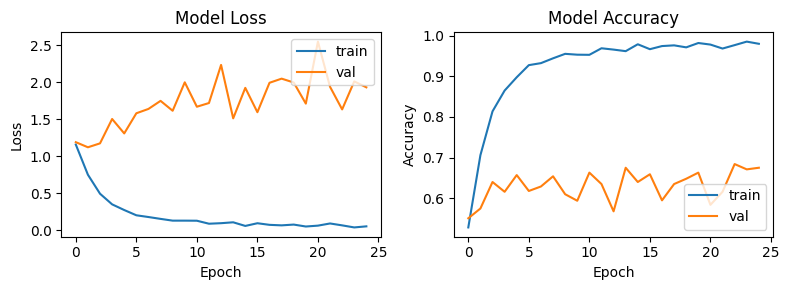

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,3))

# 훈련 손실 그래프
plt.subplot(121)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

# 훈련 정확도 그래프
plt.subplot(122)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.tight_layout()
plt.show()

In [24]:
base_model.trainable = True

In [25]:
epochs=30

In [26]:
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-5,
    decay_steps=epochs * len(y_training),
    alpha=2e-7
)

In [27]:
model.compile(optimizer=AdamW(learning_rate=lr_schedule, weight_decay = 5e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
hist=model.fit(x=x_training,y=y_training, epochs=30, validation_data=(x_test,y_test), callbacks=[earlystopping])

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 194s 219ms/step - accuracy: 0.9839 - loss: 0.0485 - val_accuracy: 0.7312 - val_loss: 1.4610
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.9912 - loss: 0.0279 - val_accuracy: 0.7352 - val_loss: 1.4427
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.9933 - loss: 0.0214 - val_accuracy: 0.7352 - val_loss: 1.4384
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.9955 - loss: 0.0141 - val_accuracy: 0.7382 - val_loss: 1.4243
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.9951 - loss: 0.0153 - val_accuracy: 0.7372 - val_loss: 1.4269
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.9967 - loss: 0.0128 - val_accuracy: 0.7402 - val_loss: 1.4265
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.9975 - loss: 0.0097 - val_accuracy: 0.7392 - val_loss: 1.4314
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.9969 - loss: 0.0118 

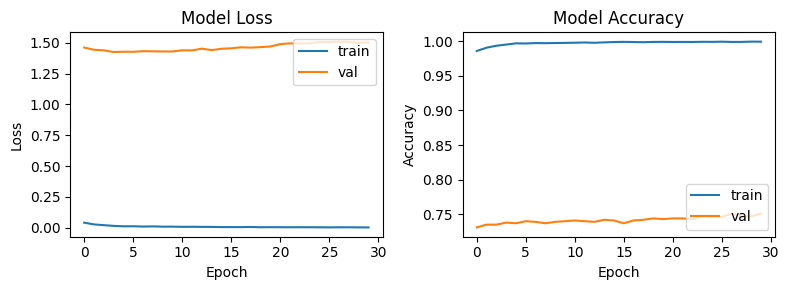

In [29]:
plt.figure(figsize=(8,3))

# 훈련 손실 그래프
plt.subplot(121)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

# 훈련 정확도 그래프
plt.subplot(122)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.tight_layout()
plt.show()

In [30]:
model.save('model.h5')

# ref
- https://velog.io/@kyyle/Model-Optimization-1-%ED%9B%88%EB%A0%A8-%ED%9B%84-%EC%96%91%EC%9E%90%ED%99%94
- https://dacon.io/competitions/official/236082/codeshare/8441